# GTHA housing market database
# OSEMN methodology Step 5: Interpret
# Classify land use from new features in Teranet (3 classes)
# Interpretation of results
Interpretation of results of land use classification using best performing model.

---

This notebook describes _Step 5: Interpret_ of OSEMN methodology performed on the Teranet dataset.

## Import dependencies

In [1]:
random_state = 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from time import time

sns.set()

In [3]:
import sys

sys.path.append('../../src')

from io_utils import df_from_csv
from plot_utils import plot_hist
from model_utils import fit_model, targets_corr, plot_learning_curve, plot_validation_curve, plot_confusion_matrix

## Load Teranet data

In [4]:
data_path = '../../data/'
teranet_path = data_path + 'teranet/'
os.listdir(teranet_path)

['1.1_Teranet_DA.csv',
 '1.3_Teranet_DA_TAZ_PG_FSA.csv',
 '4_Teranet_lu_predict_3c.csv',
 '2_Teranet_consistent.csv',
 'parcel16_epoi13.csv',
 '1.2_Teranet_DA_TAZ.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU_LUDMTI.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU.csv',
 '4_Teranet_lu_predict_4c.csv',
 '.ipynb_checkpoints',
 'ParcelLandUse.zip',
 'ParcelLandUse',
 'HHSaleHistory.csv',
 '3_Teranet_nonan_new_cols.csv',
 'GTAjoinedLanduseSales']

In [5]:
teranet_df = df_from_csv(teranet_path + '4_Teranet_lu_predict_3c.csv', parse_dates=['registration_date'])

----- DataFrame loaded
in 93.39 seconds
with 5,188,513 rows
and 79 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'price_da_pct_change

## Load Census data

In [6]:
census_path = data_path + 'census/'
os.listdir(census_path)

['da_census_income.csv',
 'Census data availability.xlsx',
 'da_census.xls',
 'da_census_select_tidy.csv',
 'da_census_income_shapefile',
 'da_census_select.csv']

In [7]:
census_df = df_from_csv(census_path + 'da_census_select_tidy.csv')

----- DataFrame loaded
in 0.17 seconds
with 36,728 rows
and 32 columns
-- Column names:
 Index(['DAUID', 'year', 'Avg_HHsize', 'Avg_HHinc', 'Avg_own_payt',
       'Avg_val_dwel', 'Avg_rent', 'Pop', 'PopDens', 'Dwel', 'DwelDens',
       'Sgl_det', 'Apt_5plus', 'Sgl_att', 'Owned', 'Rented', 'CarTrVan_d',
       'CarTrVan_p', 'PT', 'Walk', 'Bike', 'Lbrfrc', 'Emp', 'Unemp',
       'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home', 'No_fix_wkpl',
       'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object')


## Load TTS data

In [8]:
tts_path = data_path + 'tts/'
os.listdir(tts_path)

['tts_num_jobs_tidy.csv',
 'TAZ_2001shp.zip',
 'TAZ_2001shp',
 'taz_tts_tidy.csv',
 'taz_info.csv',
 'TTS_variables.xlsx',
 'taz_tts.xlsx',
 'Num_of_Jobs.xlsx']

In [9]:
tts_df = df_from_csv(tts_path + 'taz_tts_tidy.csv')

----- DataFrame loaded
in 0.01 seconds
with 12,012 rows
and 8 columns
-- Column names:
 Index(['TAZ_O', 'year', 'Pop', 'FT_wrk', 'Stu', 'HH', 'Jobs', 'Cars'], dtype='object')


## Join Census data to Teranet data

In [10]:
t = time()
df = pd.merge(teranet_df, census_df, how='left',
              left_on=['dauid', 'census2001_year'], right_on=['DAUID', 'year'])
df = df.drop(['DAUID', 'year_y'], axis=1).rename(columns={'year_x': 'year'})
elapsed = time() - t
print("----- Census variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- Census variables were joined to the DataFrame
in 55.49 seconds (0.92 minutes)
with 5,188,513 rows
and 109 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Emp', 'Unemp', 'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home',
       'No_fix_wkpl', 'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object', length=109)


## Join TTS data to Teranet data

In [11]:
t = time()
df = pd.merge(df, tts_df, how='left',
              left_on=['taz_o', 'tts_year'], right_on=['TAZ_O', 'year'])
df = df.drop(['taz_o', 'year_y'], axis=1).rename(columns={'year_x': 'year'})
elapsed = time() - t
print("----- TTS variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- TTS variables were joined to the DataFrame
in 65.27 seconds (1.09 minutes)
with 5,188,513 rows
and 115 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Usl_wkpl', 'Blue_cljob', 'White_cljob', 'TAZ_O', 'Pop_y', 'FT_wrk',
       'Stu', 'HH', 'Jobs', 'Cars'],
      dtype='object', length=115)


## Take a train-test subset of Teranet records

In [12]:
year_train_test_min = 2011
year_train_test_max = 2014
year_val1 = 2010
year_val2 = 2015

s = df.query('year >= @year_train_test_min & year <= @year_train_test_max')
s_val1 = df.query('year == @year_val1')
s_val2 = df.query('year == @year_val2')

print("{0:,} Teranet records in the train-test subset (records from {1} to {2})."
      .format(len(s), year_train_test_min, year_train_test_max))
print("{0:,} Teranet records in the validation subset #1 (records from {1}).".format(len(s_val1), year_val1))
print("{0:,} Teranet records in the validation subset #2 (records from {1}).".format(len(s_val2), year_val2))

857,896 Teranet records in the train-test subset (records from 2011 to 2014).
216,492 Teranet records in the validation subset #1 (records from 2010).
244,787 Teranet records in the validation subset #2 (records from 2015).


## Select features

In [13]:
s.columns

Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Usl_wkpl', 'Blue_cljob', 'White_cljob', 'TAZ_O', 'Pop_y', 'FT_wrk',
       'Stu', 'HH', 'Jobs', 'Cars'],
      dtype='object', length=115)

In [14]:
top11f = ['xy_total_sales', 'xy_prev_sales', 'xy_first_sale',
          'xy_years_since_last_sale', 'xy_years_to_next_sale', 'med_price_xy',
          'Avg_HHsize', 'Avg_rent', 'PopDens', 'DwelDens', 'Apt_5plus',
          'lucr']
s = s[top11f]
s_val1 = s_val1[top11f]
s_val2 = s_val2[top11f]
s.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 857896 entries, 0 to 5002104
Data columns (total 12 columns):
xy_total_sales              857896 non-null int64
xy_prev_sales               857896 non-null int64
xy_first_sale               857896 non-null bool
xy_years_since_last_sale    746796 non-null float64
xy_years_to_next_sale       575944 non-null float64
med_price_xy                857896 non-null float64
Avg_HHsize                  855523 non-null float64
Avg_rent                    855435 non-null float64
PopDens                     857896 non-null float64
DwelDens                    857896 non-null float64
Apt_5plus                   855523 non-null float64
lucr                        857896 non-null object
dtypes: bool(1), float64(8), int64(2), object(1)
memory usage: 79.4+ MB


## Fill missing values

In [15]:
col1 = 'xy_years_to_next_sale'
col2 = 'xy_years_since_last_sale'
mask1 = s[col1].isnull()
print("For records with missing '{0}', values of '{1}' are: mean={2:,.2f}, median={3:,.2f}"
      .format(col1, col2, s.loc[mask1, col2].mean(), s.loc[mask1, col2].median()))
mask1 = s[col2].isnull()
print("For records with missing '{0}', values of '{1}' are: mean={2:,.2f}, median={3:,.2f}"
      .format(col2, col1, s.loc[mask1, col1].mean(), s.loc[mask1, col1].median()))

For records with missing 'xy_years_to_next_sale', values of 'xy_years_since_last_sale' are: mean=7.72, median=6.02
For records with missing 'xy_years_since_last_sale', values of 'xy_years_to_next_sale' are: mean=2.02, median=1.69


In [16]:
# missing year to next sale is replaced with median year since last sale and vice versa
mask1 = s[col1].isnull()
s.loc[mask1, col1] = s.loc[mask1, col2].median()
mask1 = s_val1[col1].isnull()
s_val1.loc[mask1, col1] = s_val1.loc[mask1, col2].median()
mask1 = s_val2[col1].isnull()
s_val2.loc[mask1, col1] = s_val2.loc[mask1, col2].median()

mask1 = s[col2].isnull()
s.loc[mask1, col2] = s.loc[mask1, col1].median()
mask1 = s_val1[col2].isnull()
s_val1.loc[mask1, col2] = s_val1.loc[mask1, col1].median()
mask1 = s_val2[col2].isnull()
s_val2.loc[mask1, col2] = s_val2.loc[mask1, col1].median()

s.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 857896 entries, 0 to 5002104
Data columns (total 12 columns):
xy_total_sales              857896 non-null int64
xy_prev_sales               857896 non-null int64
xy_first_sale               857896 non-null bool
xy_years_since_last_sale    857896 non-null float64
xy_years_to_next_sale       857896 non-null float64
med_price_xy                857896 non-null float64
Avg_HHsize                  855523 non-null float64
Avg_rent                    855435 non-null float64
PopDens                     857896 non-null float64
DwelDens                    857896 non-null float64
Apt_5plus                   855523 non-null float64
lucr                        857896 non-null object
dtypes: bool(1), float64(8), int64(2), object(1)
memory usage: 79.4+ MB


In [17]:
s = s.dropna()
s_val1 = s_val1.dropna()
s_val2 = s_val2.dropna()
print("{0:,} rows in train-test subset, {1:,} rows in validation subset #1, {2:,} rows in validation subset #2"
      .format(len(s), len(s_val1), len(s_val2)))

855,378 rows in train-test subset, 216,155 rows in validation subset #1, 244,425 rows in validation subset #2


In [18]:
target_cols = 1
feat_cols = s.columns[:-target_cols]
feat_cols

Index(['xy_total_sales', 'xy_prev_sales', 'xy_first_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale', 'med_price_xy',
       'Avg_HHsize', 'Avg_rent', 'PopDens', 'DwelDens', 'Apt_5plus'],
      dtype='object')

In [19]:
feat_set_name = 'top11f_3c'

## Encode target

In [20]:
le = LabelEncoder()

s['lucr_e'] = le.fit_transform(s['lucr'])
s_val1['lucr_e'] = le.transform(s_val1['lucr'])
s_val2['lucr_e'] = le.transform(s_val2['lucr'])

print(s['lucr'].value_counts().sort_index())
print(s['lucr_e'].value_counts().sort_index())
print(s_val1['lucr'].value_counts().sort_index())
print(s_val1['lucr_e'].value_counts().sort_index())
print(s_val2['lucr'].value_counts().sort_index())
print(s_val2['lucr_e'].value_counts().sort_index())

s = s.drop(['lucr'], axis=1)
s_val1 = s_val1.drop(['lucr'], axis=1)
s_val2 = s_val2.drop(['lucr'], axis=1)
print("Land use encoded!")

condo    222904
house    288879
other    343595
Name: lucr, dtype: int64
0    222904
1    288879
2    343595
Name: lucr_e, dtype: int64
condo    66944
house    77497
other    71714
Name: lucr, dtype: int64
0    66944
1    77497
2    71714
Name: lucr_e, dtype: int64
condo     57424
house     76798
other    110203
Name: lucr, dtype: int64
0     57424
1     76798
2    110203
Name: lucr_e, dtype: int64
Land use encoded!


## Prepare features

### Select features and target

In [21]:
X = s[feat_cols].values
X_val1 = s_val1[feat_cols].values
X_val2 = s_val2[feat_cols].values
y = s['lucr_e'].values
y_val1 = s_val1['lucr_e'].values
y_val2 = s_val2['lucr_e'].values
print("Features and target selected.")

Features and target selected.


### Perform the train-test split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y)
print("Performed train-test split.")
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))
print('Labels counts in y_val1:', np.bincount(y_val1))
print('Labels counts in y_val2:', np.bincount(y_val2))

Performed train-test split.
Labels counts in y: [222904 288879 343595]
Labels counts in y_train: [156033 202215 240516]
Labels counts in y_test: [ 66871  86664 103079]
Labels counts in y_val1: [66944 77497 71714]
Labels counts in y_val2: [ 57424  76798 110203]


## Best performing model

### Accuracy score

In [23]:
n_jobs = 12
n_estimators = 50
model_name = "Random Forest\n('gini' criterion, n_estimators={0})".format(n_estimators)
model_code = 'forest{0}'.format(n_estimators)
forest = RandomForestClassifier(criterion='gini', random_state=random_state, n_jobs=n_jobs, n_estimators=n_estimators)
forest.fit(X_train, y_train)
forest.score(X_test, y_test)

0.9687546275729305

### Classification reports (precision, recall, f-1 score by class; macro / weighted average)

#### Train-test subset

In [24]:
subset = 'train-test'
cr = classification_report(y_test, forest.predict(X_test), output_dict=True, target_names=le.classes_)
print("Classification report for {0}, {1} subset".format(model_name, subset))
pd.DataFrame(cr)

Classification report for Random Forest
('gini' criterion, n_estimators=50), train-test subset


,condo,house,other,accuracy,macro avg,weighted avg
precision,0.996800,0.940099,0.975766,0.968755,0.970888,0.969202
recall,0.992179,0.973011,0.949980,0.968755,0.971723,0.968755
f1-score,0.994484,0.956272,0.962700,0.968755,0.971152,0.968812
support,66871.000000,86664.000000,103079.000000,0.968755,256614.000000,256614.000000


#### Extra validation subset \#1

In [25]:
subset='extra validation #1'
cr = classification_report(y_val1, forest.predict(X_val1), output_dict=True, target_names=le.classes_)
print("Classification report for {0}, {1} subset".format(model_name, subset))
pd.DataFrame(cr)

Classification report for Random Forest
('gini' criterion, n_estimators=50), extra validation #1 subset


,condo,house,other,accuracy,macro avg,weighted avg
precision,0.993682,0.925138,0.934953,0.949411,0.951257,0.949622
recall,0.986675,0.946888,0.917352,0.949411,0.950305,0.949411
f1-score,0.990166,0.935887,0.926069,0.949411,0.950707,0.949440
support,66944.000000,77497.000000,71714.000000,0.949411,216155.000000,216155.000000


#### Extra validation subset \#2

In [26]:
subset='extra validation #1'
cr = classification_report(y_val2, forest.predict(X_val2), output_dict=True, target_names=le.classes_)
print("Classification report for {0}, {1} subset".format(model_name, subset))
pd.DataFrame(cr)

Classification report for Random Forest
('gini' criterion, n_estimators=50), extra validation #1 subset


,condo,house,other,accuracy,macro avg,weighted avg
precision,0.802790,0.902602,0.91708,0.882622,0.874157,0.885680
recall,0.882993,0.977057,0.81662,0.882622,0.892223,0.882622
f1-score,0.840984,0.938355,0.86394,0.882622,0.881093,0.881928
support,57424.000000,76798.000000,110203.00000,0.882622,244425.000000,244425.000000


### Confusion matrices

#### Train-test subset

Random Forest
('gini' criterion, n_estimators=50)
train-test subset
Confusion matrix, without normalization
[[66348   406   117]
 [   24 84325  2315]
 [  189  4967 97923]]


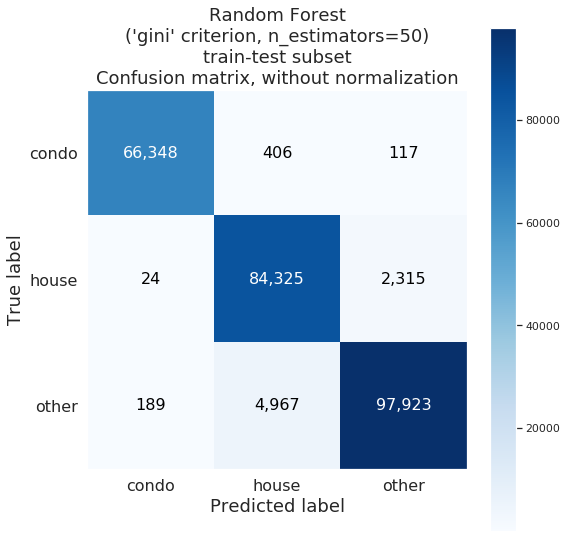

In [27]:
subset = 'train-test'
np.set_printoptions(precision=2)
model_name_subset = model_name + '\n{0} subset'.format(subset)
plot_confusion_matrix(y_test, forest.predict(X_test), le.classes_, model_name_subset, width=8)
plt.show()

Random Forest
('gini' criterion, n_estimators=50)
train-test subset
Normalized confusion matrix
[[9.92e-01 6.07e-03 1.75e-03]
 [2.77e-04 9.73e-01 2.67e-02]
 [1.83e-03 4.82e-02 9.50e-01]]


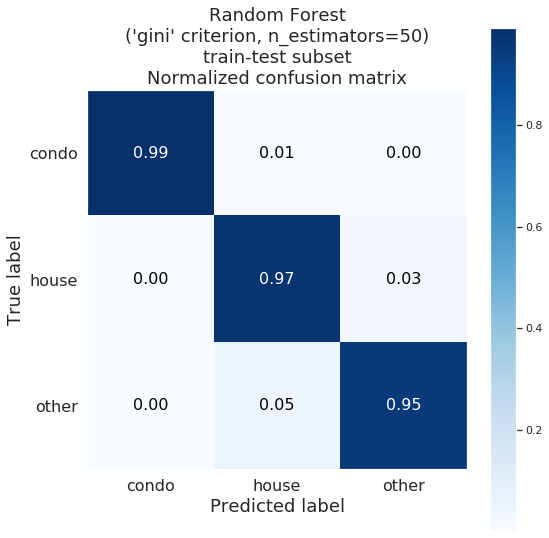

In [28]:
subset = 'train-test'
model_name_subset = model_name + '\n{0} subset'.format(subset)
plot_confusion_matrix(y_test, forest.predict(X_test), le.classes_, model_name_subset, normalize=True, width=8)
plt.show()

#### Extra validation subset \#1

Random Forest
('gini' criterion, n_estimators=50)
validation #1 subset
Confusion matrix, without normalization
[[66052   412   480]
 [   19 73381  4097]
 [  401  5526 65787]]


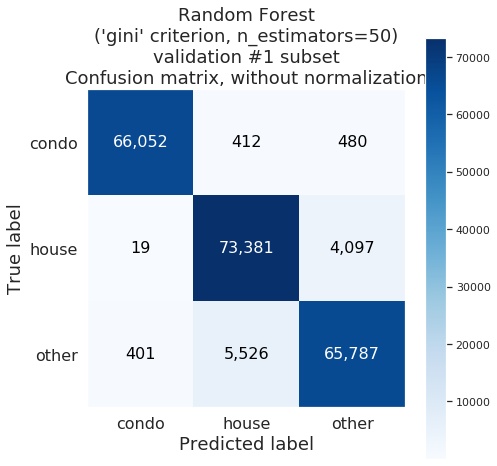

In [29]:
subset = 'validation #1'
model_name_subset = model_name + '\n{0} subset'.format(subset)
plot_confusion_matrix(y_val1, forest.predict(X_val1), le.classes_, model_name_subset, width=7)
plt.show()

Random Forest
('gini' criterion, n_estimators=50)
validation #1 subset
Normalized confusion matrix
[[9.87e-01 6.15e-03 7.17e-03]
 [2.45e-04 9.47e-01 5.29e-02]
 [5.59e-03 7.71e-02 9.17e-01]]


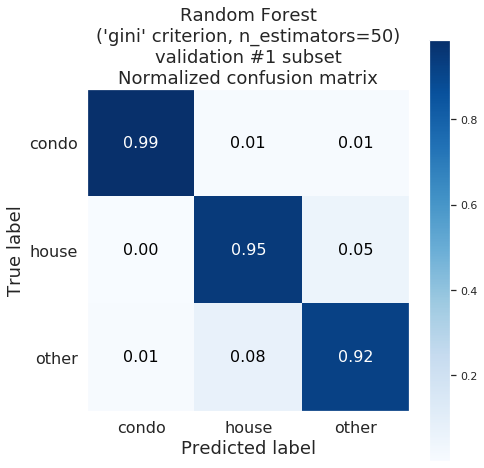

In [30]:
subset = 'validation #1'
model_name_subset = model_name + '\n{0} subset'.format(subset)
plot_confusion_matrix(y_val1, forest.predict(X_val1), le.classes_, model_name_subset, width=7, normalize=True)
plt.show()

#### Extra validation subset \#2

Random Forest
('gini' criterion, n_estimators=50)
validation #2 subset
Confusion matrix, without normalization
[[50705   304  6415]
 [   40 75036  1722]
 [12416  7793 89994]]


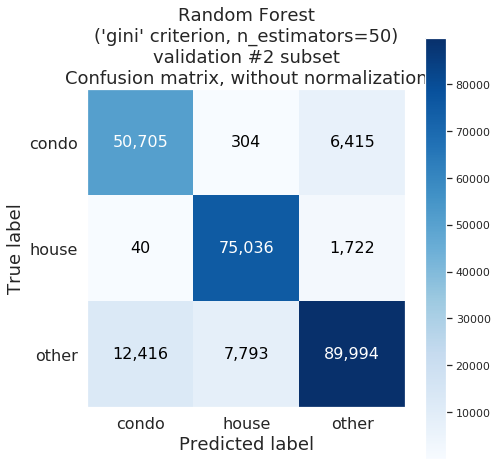

In [31]:
subset = 'validation #2'
model_name_subset = model_name + '\n{0} subset'.format(subset)
np.set_printoptions(precision=2)
plot_confusion_matrix(y_val2, forest.predict(X_val2), le.classes_, model_name_subset, width=7)
plt.show()

Random Forest
('gini' criterion, n_estimators=50)
validation #2 subset
Normalized confusion matrix
[[8.83e-01 5.29e-03 1.12e-01]
 [5.21e-04 9.77e-01 2.24e-02]
 [1.13e-01 7.07e-02 8.17e-01]]


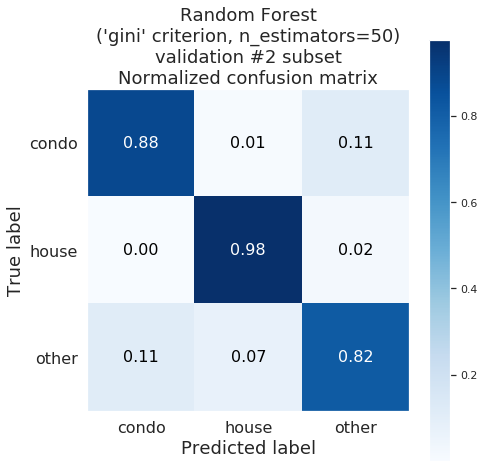

In [32]:
np.set_printoptions(precision=2)
plot_confusion_matrix(y_val2, forest.predict(X_val2), le.classes_, model_name_subset, width=7, normalize=True)
plt.show()

#### Feature importance

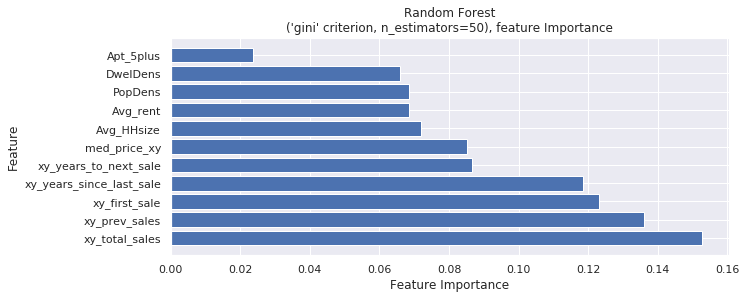

In [33]:
# plot feature importances from Random Forest
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

f, ax = plt.subplots(1, figsize=(10, 4))
ax.set_title('{0}, feature Importance'.format(model_name))
plt.barh(feat_cols, importances[indices], align='center')
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Feature')
f.savefig('results/plots/{0}_{1}_feature_importance.png'.format(feat_set_name, model_code))

In [34]:
scores_tidy = scores_df.reset_index().rename(columns={'index': 'model'})\
                       .melt(id_vars='model', var_name='subset', value_name='score').sort_values(['model', 'subset'])

f, ax = plt.subplots(1, figsize=(5, 6))
sns.barplot(x="subset", y="score", hue="model", order=['train', 'test', 'val1', 'val2'],
                                                       data=scores_tidy, palette="muted", ax=ax)
ax.set_ylabel("Model accuracy", fontsize=16)
ax.set_xlabel("Subset of Teranet records", fontsize=16)
ax.set_title("Accuracy of models of train, test and 2 validation sets\n'{0}' feature set".format(feat_set_name), 
             fontsize=16)
ax.grid(True)
ax.legend(loc='center left', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_ylim(0.6, 1.0)
plt.savefig('../../results/plots/{0}_best_model_performance.png'.format(feat_set_name), bbox_inches='tight')

NameError: name 'scores_df' is not defined

## Predict `lucr` using the best performing model

In [ ]:
# set model name and hyperparameters
n_jobs = 12
n_estimators = 50
model_name = "Random Forest\n('gini' criterion, n_estimators={0})".format(n_estimators)
model_code = 'forest{0}'.format(n_estimators)
forest = RandomForestClassifier(criterion='gini', random_state=random_state, n_jobs=n_jobs, n_estimators=n_estimators)

t = time()
# predict lucr using best performing model
forest = RandomForestClassifier(criterion='gini', n_estimators=n_trees, random_state=1, n_jobs=8)
forest.fit(X_train, y_train)
s[predict_col_name] = forest.predict(X)
s_val1[predict_col_name] = forest.predict(X_val1)
s_val2[predict_col_name] = forest.predict(X_val2)

elapsed = time() - t
print("lucr predicted, took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))